# Final Project: Identifying Target Populations for Accessible CTA Stations

In Chicago, the city is currently carrying out the initiative ASAP--All Stations Accesssible for All People, which seeks to update the remaining non-ADA accessible rail stations.  A large part of the beginning stages of this project involves identifying the stations and communities most in need of accessible updates, depending on where they are and how near to other accessible forms of transit they are.  In this project, I looked at census data to estimate the number of people currently affected by non-accessible transit nodes.  

This project will hopefully eventually be an accessible RShiny package, the portions of which you can see here in the leaflet maps.  However, this will need to be a later extension of this project.  

# # Step 1: Finding Data

Note: In this section I include the code that I used for data wrangling; however, for ease of use I've attached all data for visualization as an .Rdata file later on.  


I used the tidycensus package to locate the following census information by tract: total population, number of people with disabilities, number of people with ambulatory disabilities, number of black people (as a stand in for further demographic analysis), median income, and percentage employed.  One perk of using tidycensus is that census data calls can be easily adapted to any city of interest, rather than having to do direct downloads from American FactFinder.  A sample of this kind of API call is below:

To install your API key for use in future sessions, run this function with `install = TRUE`.
Getting data from the 2013-2017 5-year ACS
Using the ACS Data Profile


  |======================================================================| 100%


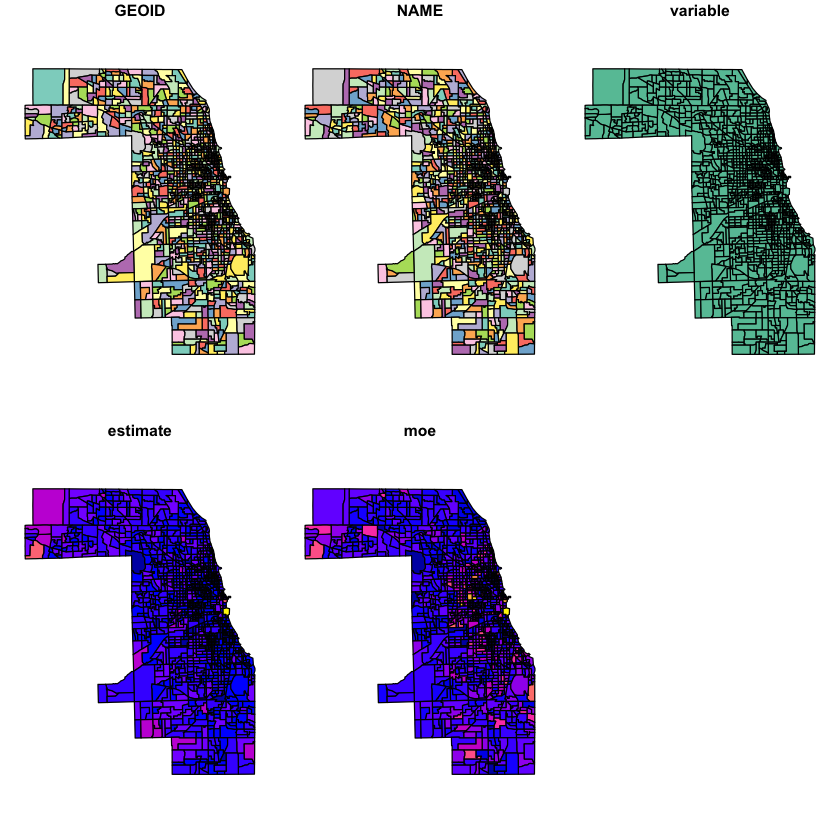

In [1]:
library(tidycensus)
census_api_key("f1318fa2adc9b2cb675a37a2efd7be9f31cd6917", overwrite = TRUE, install = FALSE)

ada_population <- get_acs(geography = "tract", variables = "DP02_0070E", year = 2017, endyear = NULL,
        output = "tidy", state = "Illinois", county="Cook County", geometry = TRUE)
plot(ada_population)

We then can load all the other data:

In [ ]:
black_perc <-  get_acs(geography = "tract", variables = "DP05_0038PE", year = 2017, endyear = NULL,
                       output = "tidy", state = "Illinois", county="Cook County", geometry = TRUE)
employed_perc <- get_acs(geography = "tract", variables = "DP03_0001PE", year = 2017, endyear = NULL,
                         output = "tidy", state = "Illinois", county="Cook County", geometry = TRUE)
  
med_house_income_census <- get_acs(geography = "tract", variables = "DP03_0062E", year = 2017, endyear = NULL,
                          output = "tidy", state = "Illinois", county="Cook County", geometry = TRUE)
plot(med_house_income_census)

ambulatory_est <- get_acs(geography = "tract", variables = "S1810_C02_047E", year = 2017, endyear = NULL,
                          output = "tidy", state = "Illinois", county="Cook County", geometry = TRUE)
total_pop <- get_acs(geography = "tract", variables = "B00001_001E", year = 2017, endyear = NULL,
                     output = "tidy", state = "Illinois", county="Cook County", geometry = TRUE)
#cleaning up data to have totals and percentages for all
amb_perc <- cbind(ambulatory_est, total_pop)
amb_perc$perc <- (amb_perc$estimate/amb_perc$estimate.1)

total_pop$total <- total_pop$total
amb_perc$total <- amb_perc$estimate
ada_pop$total <- ada_pop$estimate
black_perc$total <- black_perc$estimate*total_pop$total


After that, I downloaded the Chicago Data Portal shapefiles of the CTA bus and rail networks.  Although this could also be achieved through an API, I used a direct download since this API isn't usable across cities.

In [4]:
library(rgdal)
library(sp)

llines <- readOGR(".", "CTA_RailLines")
lstops <- readOGR(".", "CTA_RailStations")
busstops <- readOGR(".", "CTA_BusStops")
buslines <- readOGR(".", "CTA_BusRoutes")


ERROR: Error in ogrInfo(dsn = dsn, layer = layer, encoding = encoding, use_iconv = use_iconv, : Cannot open data source


I then immediately changed the CRS to EPSG=4326 in order to be compatible with Leaflet later on.  

In [ ]:
CRS.new <- "(+init=epsg:4326)"
llines <- spTransform(llines, CRS.new)
#etc

Next, I identified the non-ADA accessible stations: 

In [ ]:
ada_stops <- subset(lstops, ADA==1)

Let's see where we're at now with a visualization of some of our demographics data and the CTA lines

In [7]:
library(leaflet)
library(magrittr)
library(sp)

#testing data
load(url("https://github.com/renwah/GIS-III/blob/master/finalproj.RData?raw=True"))


leaflet() %>% addPolylines(data=llines, group = "L Station Network") %>% 
  addMarkers(data=lstops, group =  "L Station Network") %>%
  addPolygons(data=ada_pop_sp, group = "Demographics", color = "#444444", weight = 1, smoothFactor = 0.5,
              opacity = 1.0, fillOpacity = 0.5,
              fillColor = ~colorQuantile("YlOrRd", total)(total),
              highlightOptions = highlightOptions(color = "white", weight = 2,
                                                  bringToFront = TRUE)) %>%
  addTiles() %>%
  #layer toggle
  addLayersControl(
    overlayGroups = c("L Station Network", "Demographics"),
    options = layersControlOptions(collapsed = FALSE))

HTML widgets cannot be represented in plain text (need html)

ERROR: Error in UseMethod("st_transform"): no applicable method for 'st_transform' applied to an object of class "c('SpatialPointsDataFrame', 'SpatialPoints', 'Spatial', 'SpatialVector', 'SpatialPointsNULL')"
